# [Module 1.2] 데이터 탐색 


이 노트북을 모두 실행하는데 걸리는 시간은 약 20 ~ 30 분 소요 됩니다.



In [1]:
import boto3
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt

In [9]:
%store -r

## 데이타 셋 로딩

df_warm_train 로딩

In [14]:
pd.options.display.max_rows = 5
df_warm = pd.read_csv(warm_interation_filename)
# df_warm_train = pd.read_csv(warm_train_interaction_filename)
# df_warm_holdout = pd.read_csv(validation_interaction_filename)
# df_coldstart = pd.read_csv(coldstart_interation_filename)

### Train 데이터의 유저 액티비티 통계

Train 분포는 아래와 같습니다. <br>
**유저에 대해서 최소는 2번이고, 중간값은 40번, 최대는 1019번을 rating을 했습니다.**

- 참고로 Warm, ColdStart 분할 전의 전체 분포는 아래와 같습니다. 참고 하세요.
Interaction 분포는 아래와 같습니다. <br>
유저에 대해서 최소는 20번이고, 중간값은 96번, 최대는 2314번을 rating을 했습니다.

In [4]:
pd.options.display.max_rows = 10
user_activity_counts = df_warm_train.groupby("USER_ID").count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":"INTERACTION_COUNTS"})
user_activity_counts.describe()

,INTERACTION_COUNTS
count,6040.000000
mean,71.718543
std,85.889218
min,2.000000
25%,18.000000
50%,40.000000
75%,90.000000
max,1029.000000


In [5]:
user_interaction_counts=user_activity_counts.reset_index()
activities = user_interaction_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']
activities

,NUM_USERS
INTERACTION_COUNTS,
2,1
3,2
4,6
5,21
6,38
...,...
670,1
717,1
766,1


인터렉션이 최소인 20번에서 75번까지의 유저수의 분포를 확인 합니다.

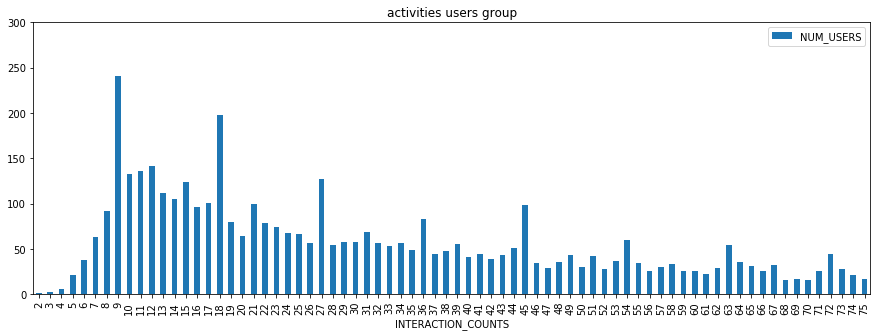

In [6]:
num_interactions = 75
activities.loc[:num_interactions,:].plot(kind='bar', figsize=(15,5), ylim=(0,300))
plt.title("activities users group")

plt.show()

인터렉션이 최소인 2번에서 1019번까지의 유저수의 분포를 확인 합니다.

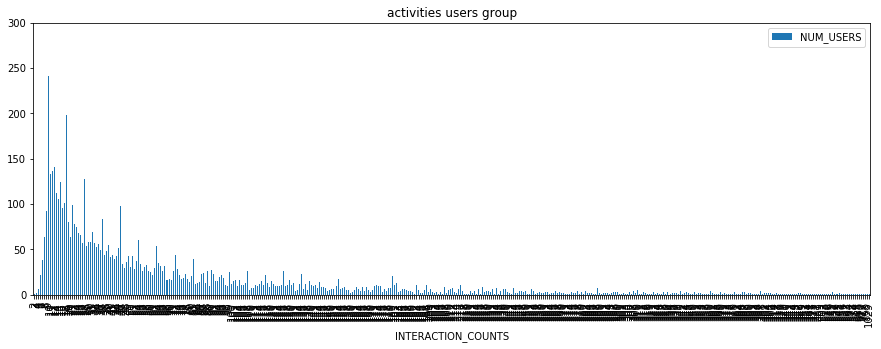

In [7]:
num_interactions = 1029
activities.loc[:num_interactions,:].plot(kind='bar', figsize=(15,5), ylim=(0,300))
plt.title("activities users group")

plt.show()

### User Search

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,1,1193,5,978300760,RATING
1,1,2804,5,978300719,RATING
2,1,2398,4,978302281,RATING
3,1,1035,5,978301753,RATING
4,1,2018,4,978301777,RATING
...,...,...,...,...,...
515858,6040,1091,1,956716541,RATING
515859,6040,1094,5,956704887,RATING
515860,6040,562,5,956704746,RATING
515861,6040,1096,4,956715648,RATING


In [21]:

from utils import get_readable_date
def get_rich_dataset(df_interaction, df_item):
    df_r = df_interaction.copy()
    df_r.drop(['EVENT_TYPE'], axis=1, inplace=True)
    df_r.drop(['EVENT_VALUE'], axis=1, inplace=True)    

    # Add readable date
    data_col_val = df_r.TIMESTAMP.apply(lambda x: get_readable_date(int(x)))
    df_r.insert(len(df_r.columns),column="DATE", value=data_col_val)    
    # Add item_title, genre using join opeation
    df_r = df_r.merge(df_item, on='ITEM_ID', how='inner')
    col_order = ['USER_ID', 'ITEM_ID','TITLE', 'GENRE', 'TIMESTAMP', 'DATE']
    df_r = df_r[col_order]
    return df_r



In [19]:
df_warm = pd.read_csv(warm_interation_filename)
df_warm_train = pd.read_csv(warm_train_interaction_filename)
df_warm_holdout = pd.read_csv(validation_interaction_filename)
df_coldstart = pd.read_csv(coldstart_interation_filename)
items = pd.read_csv('./ml-1m/movies.dat',sep='::', encoding='latin1',names=['ITEM_ID', 'TITLE', 'GENRE'],)

df_warm_rich = get_rich_dataset(df_warm, items_meta)
df_warm_train_rich = get_rich_dataset(df_warm_train, items_meta)
df_warm_holdout_rich = get_rich_dataset(df_warm_holdout, items_meta)
df_coldstart_rich = get_rich_dataset(df_coldstart, items_meta)

## 특정 유저 탐색

완료되면 파일을 새 CSV로 저장한 다음, S3에 업로드합니다.<br>

In [20]:
# pd.options.display.max_rows = 70
# df_warm[df_warm.USER_ID == 2].sort_values(by='TIMESTAMP')

USER_ID = 2

user_warm_list = df_warm[df_warm.USER_ID == USER_ID].sort_values(by='TIMESTAMP').ITEM_ID.values
user_warm_train_list = df_warm_train[df_warm_train.USER_ID == USER_ID].sort_values(by='TIMESTAMP').ITEM_ID.values
user_warm_holdout_list = df_warm_holdout[df_warm_holdout.USER_ID == USER_ID].sort_values(by='TIMESTAMP').ITEM_ID.values
user_coldstart_list = df_coldstart[df_coldstart.USER_ID == 1].sort_values(by='TIMESTAMP').ITEM_ID.values

print("\nwarm in order of TIMESTAMP: \n", user_warm_list)
print("\nwarm_train in order of TIMESTAMP: \n", user_warm_train_list)
print("\nwarm_holdout_list in order of TIMESTAMP: \n", user_warm_holdout_list)

print("\nwarm sorted: \n", sorted(user_warm_list))
print("coldstart: \n", sorted(user_coldstart_list))


warm in order of TIMESTAMP: 
 [1198 1210 1217 2717 2943 1225  318 1945 1207 3095  515 1873 1090 2067
  110 1357 1957 1953  920 1962 1834 1784  902 3334 3578 3068 1253 3071
 3699 1245 3678 1442 3255 1124  498 1537 2321 2359  356 3108 3809 1265
  589  380 2916   21 1408 3256 1370 2427 1372 1552 2490  780  459 3107
  165  368 1597  442 2628 1690 3257  736  292   95 1917 1544 1687]

warm_train in order of TIMESTAMP: 
 [1198 1210 1217 2717 2943 1225  318 1945 1207 3095  515 1873 1090 2067
  110 1357 1957 1953  920 1834 1962 1784  902 3578 3334 3068 3071 1253
 3699 1245 3678 1442 3255  498 1124 1537 2321 2359  356 3108 3809 1265
  589  380 2916   21 3256 1408 1370 2427 1372 1552 2490  780 3107  368
  459  165  442 1597 2628 1690]

warm_holdout_list in order of TIMESTAMP: 
 [3257  736  292   95 1687 1544 1917]

warm sorted: 
 [21, 95, 110, 165, 292, 318, 356, 368, 380, 442, 459, 498, 515, 589, 736, 780, 902, 920, 1090, 1124, 1198, 1207, 1210, 1217, 1225, 1245, 1253, 1265, 1357, 1370, 1372, 1

train, item, validation(holdout) 데이터를 로컬에 csv 파일로 저장 합니다.